In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import re
import itertools
import collections
import operator

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [15., 6.]

--------------

First of all, lets show how we downloaded our data and show which features we seleced:  

![image](screen_1.png)  

For completely solution was selected the following features:  

   - `Id`: post identificator  
   - `PostTypeId`: information about type of the following post  
   - `CreationDate`: date of creation. Need to select posts with appropriate dates  
   - `Score`: information about post score  
   - `ViewCount`: how many viewers have seen this post  
   - `Body`: post body. Typically is a question  
   - `Title`: post title.
   - `Tags`: which tags this post marked. 
   
   
Also will be neccesary to upload comments and answers table.  

![image](screen_2.png)  

Where:  

   - `Id`: comment Id  
   - `PostId`: Id on the post which was the main one  
   - `Text`: Body of the comment  
   - `CreationDate`: Date of creation   
   
-----

Ok, lets upload tables and prepare them

In [3]:
posts_data = pd.read_csv('QueryResults.csv')
posts_data.head(5)

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,Title,Tags
0,70503999,2,2021-12-28 07:34:52,0,NaN,<p>I found a way that seems to at least load t...,NaN,NaN
1,70504000,2,2021-12-28 07:34:58,1,NaN,<pre><code>mysql&gt; explain SELECT col3 FROM ...,NaN,NaN
2,70504001,2,2021-12-28 07:35:00,0,NaN,"<p>After a lot of searching around, I found th...",NaN,NaN
3,70504002,1,2021-12-28 07:35:03,0,76.0,<p>I want remove special character from <code>...,Remove special character from customerId colum...,<sql-server><azure-data-factory>
4,70504003,2,2021-12-28 07:35:04,0,NaN,<p>You can't use minus sign in object name dep...,NaN,NaN


In [4]:
fillna_vals = {'ViewCount': 0, 'Title': '', 'Tags': '', 'Body': ''}
posts_data.fillna(value = fillna_vals, inplace = True)
posts_data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,Title,Tags
0,70503999,2,2021-12-28 07:34:52,0,0.0,<p>I found a way that seems to at least load t...,,
1,70504000,2,2021-12-28 07:34:58,1,0.0,<pre><code>mysql&gt; explain SELECT col3 FROM ...,,
2,70504001,2,2021-12-28 07:35:00,0,0.0,"<p>After a lot of searching around, I found th...",,
3,70504002,1,2021-12-28 07:35:03,0,76.0,<p>I want remove special character from <code>...,Remove special character from customerId colum...,<sql-server><azure-data-factory>
4,70504003,2,2021-12-28 07:35:04,0,0.0,<p>You can't use minus sign in object name dep...,,


--------

In [5]:
comments_data = pd.read_csv('QueryResults_1.csv')
comments_data.head(5)

,Id,PostId,Text,CreationDate
0,121959106,69006188,How large is arr?,2021-09-01 00:00:05
1,121959108,63701554,The backing fields for `init` properties are a...,2021-09-01 00:00:35
2,121959109,69005989,@P.... I just edited.,2021-09-01 00:00:39
3,121959110,68994429,"Great, that works! Thank you so much. Side not...",2021-09-01 00:00:40
4,121959111,69006395,I in fact do have the permission! I'll check t...,2021-09-01 00:00:45


--------

Let's see what words and phrases can occur most often?

In [6]:
# procedure for careating only text
# Not ideal, but it may come up
def prepare_text(string):
    pr_1 = re.sub(
        r'<a(.+?)/a>|\n|\.|\,|\-|\*|\;|\:', 
        ' ', string)
    return re.sub(
        r'\s+', ' ', ''.join(re.findall(r'<p>(.+?)</p>', pr_1))
    ).lower()

posts_data['FullText'] = posts_data['Body'].apply(prepare_text)
posts_data['Title'] = posts_data['Title'].apply(lambda x: x.lower())
posts_data['Tags'] = posts_data['Tags'].apply(lambda x: ' '.join(re.findall(r'<(.+?)>', x)))

In [7]:
# Prepare comments
comments_data_new = comments_data.groupby('PostId').agg(list).reset_index()
posts_data.merge(comments_data_new, left_on='Id', right_on='PostId', how='left')
posts_data.columns.rename(('Id', 'PostTypeId', 'CreationDate', 
                           'Score', 'ViewCount', 'Body', 'Title', 'Tags', 
                           'FullText', 'PostId', 'commentsId', 'commentsText', 
                           'CommentsDate'), inplace = True)

--------
We have bag of words with their frequencies. Now it will be better to remove prepositions and other introductory constructions in the proposals. This is done because they do not carry a strong semantic load

In [8]:
# define words and phrases which we need to remove from our list
# Can add new elements or remove it
bad_words_arr = ['the', 'to', 'i', 'a', 'is', 'and', 'in', 'of', 'it', 'this', 
                 'you', 'that', 'for', 'with', 'have', 'can', 'but', '&lt', 
                 'on', 'be', 'under', 'from', 'an', 'are', 'in the', 'your', 
                 'when', 'will', 'i am', 'by', '=', 'then', '{', '}', 'all', 
                 "i'm", 'would', 'to the', 'at', '0', '1', '2', '3', '4', '5',
                 'also', 'has' 'on the', 'we', 'he', 'she', 'it is', 'is a', 
                 'because', 'but', 'but i', 'as', 'if', 'so', '&quout', 'as i', 
                 'am', 'want to', 'just', 'here', 'me', 'its', 'here is', 
                 'not', 'my', 'to be', 'was', 'is the', 'into']

# Define function for words
def get_freq_arr_from_text(data = posts_data, bad_words_arr = bad_words_arr, date = None):
    posts_text_arr = []
    
    if date is not None:
        data = data[data['CreationDate']>date]
    for i in range(data.shape[0]):
        new_bag = data['FullText'].values[i].split()
        posts_text_arr+=new_bag
        posts_text_arr+=[' '.join((new_bag[k], new_bag[k+1])) for k in range(len(new_bag)-1)]
        
    freq_dict = dict(collections.Counter(posts_text_arr))
    sorted_tuples = sorted(freq_dict.items(), key=operator.itemgetter(1))[::-1]
    sorted_freq = {k: v for k, v in sorted_tuples}
    
    for word in bad_words_arr:
        try:
            del sorted_freq[word]
        except: 
            continue
            
    return sorted_freq

In [9]:
freq_list_all = get_freq_arr_from_text()
arr_1 = np.array(list(freq_list_all.items()))

# Need for normalization
sum_of_words = sum(list(freq_list_all.values()))

freq_list_all = get_freq_arr_from_text()
arr_1 = np.array(list(freq_list_all.items()))
labels_arr = arr_1[:60][:,0]
values_arr = [int(k) for k in arr_1[:60][:, 1]]

In [10]:
# Check statistics for last 2 months. For more months need more memory (or better algorithm:))

date_arr_list = []
labels_list = []
vals_sum = []
# Need to add one more
date_list = ['2022-01-01']
for d in date_list:
    freq_list_1 = get_freq_arr_from_text(date = d)
    arr_2 = np.array(list(freq_list_1.items()))
    labels_list.append(arr_1[:60][:,0])
    date_arr_list.append([int(k) for k in arr_1[:60][:,1]])
    vals_sum.append(sum(list(freq_list_1.values())))

No handles with labels found to put in legend.


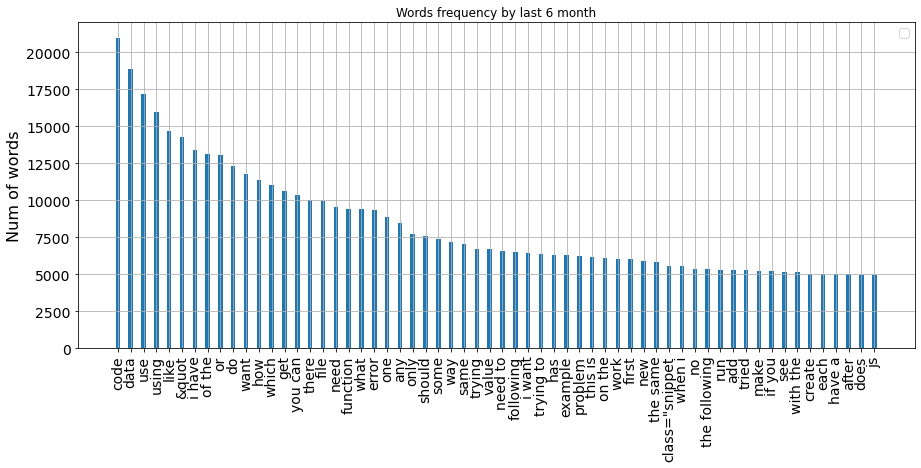

No handles with labels found to put in legend.


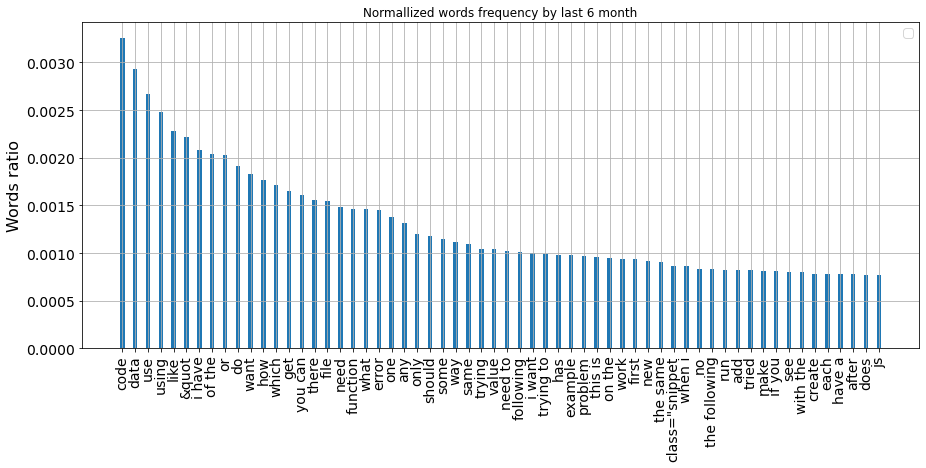

In [11]:
labels = labels_arr
width = 0.35

fig, ax = plt.subplots()
plt.bar(labels, values_arr, width, label='')

plt.ylabel('Num of words')
plt.title('Words frequency by last 6 month')
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

plt.show()


fig, ax = plt.subplots()
plt.bar(labels, [k/sum_of_words for k in values_arr], width, label='')

plt.ylabel('Words ratio')
plt.title('Normallized words frequency by last 6 month')
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


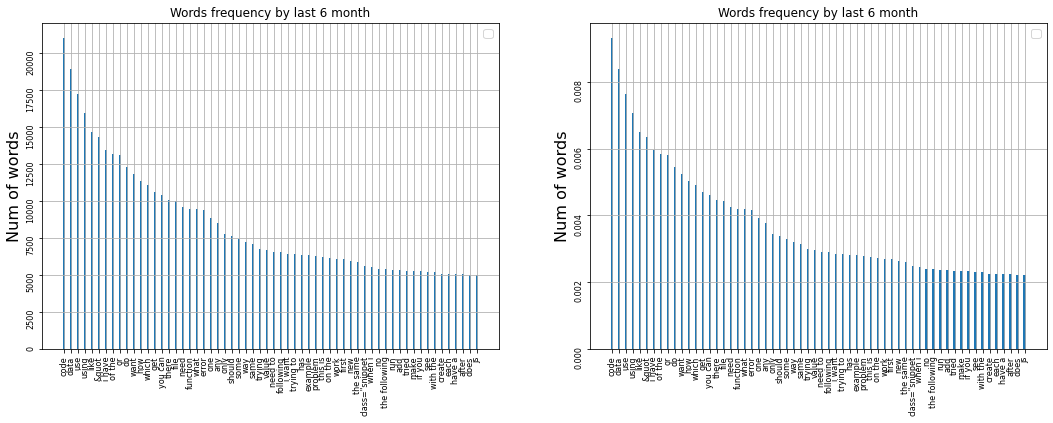

In [24]:
labels = labels_arr
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
axs[0].bar(labels_list[0], date_arr_list[0], width, label='')
axs[0].set_ylabel('Num of words')
axs[0].set_title('Words frequency by last month')
axs[0].legend()
axs[0].grid()
axs[0].tick_params(rotation=90, labelsize=8)

axs[1].bar(labels_list[0], np.array(date_arr_list[0])/vals_sum[0], width, label='')
axs[1].set_ylabel('Num of words')
axs[1].set_title('Words frequency by last month')
axs[1].legend()
axs[1].grid()
axs[1].tick_params(rotation=90, labelsize=8)

plt.show()

----------

Ok, what about tags?

In [51]:
tags_df = posts_data['Tags'].apply(lambda x: x.split(' ')).explode()
most_tags_labels = tags_df.value_counts().keys()[1:50]
most_tags_values = tags_df.value_counts().values[1:50]

No handles with labels found to put in legend.


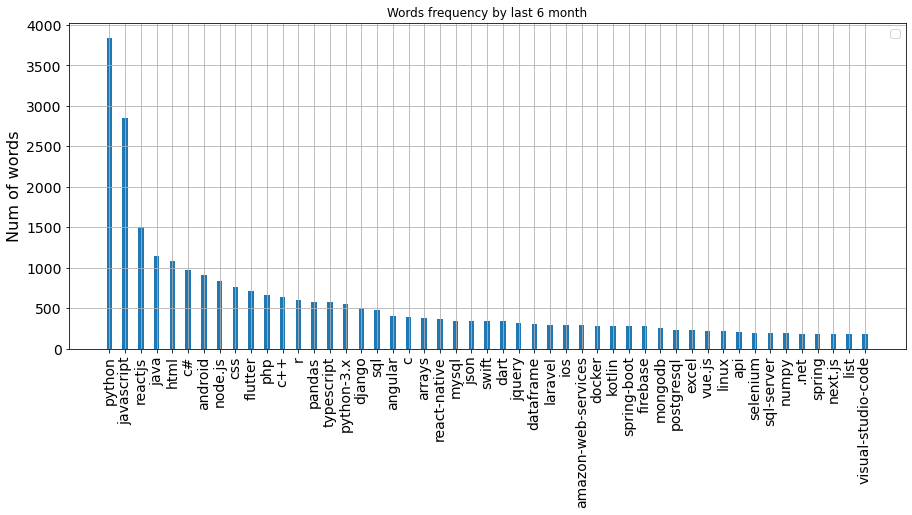

In [52]:
labels = labels_arr
width = 0.35

fig, ax = plt.subplots()
plt.bar(most_tags_labels, most_tags_values, width, label='')

plt.ylabel('Num of tags')
plt.title('Tags frequancy last 6 month')
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

plt.show()

------------

What about temporal effect?

No handles with labels found to put in legend.


0  months ago


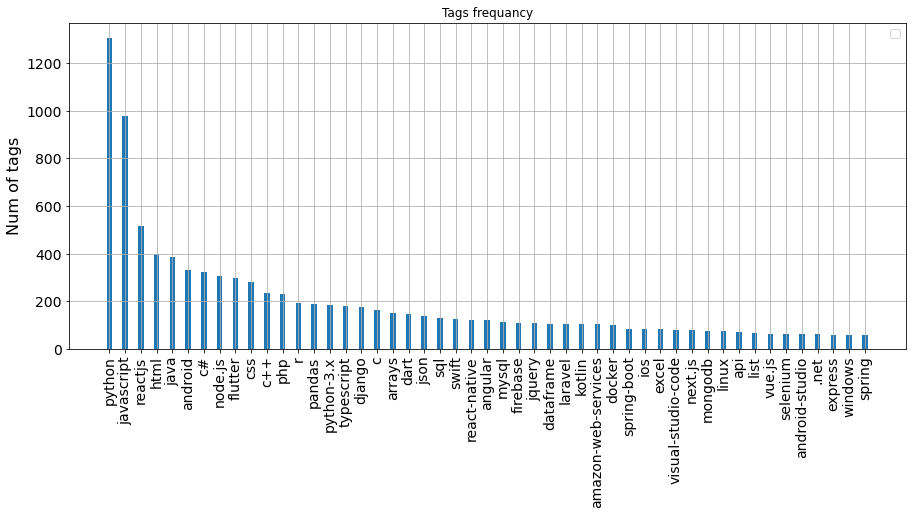

No handles with labels found to put in legend.


1  months ago


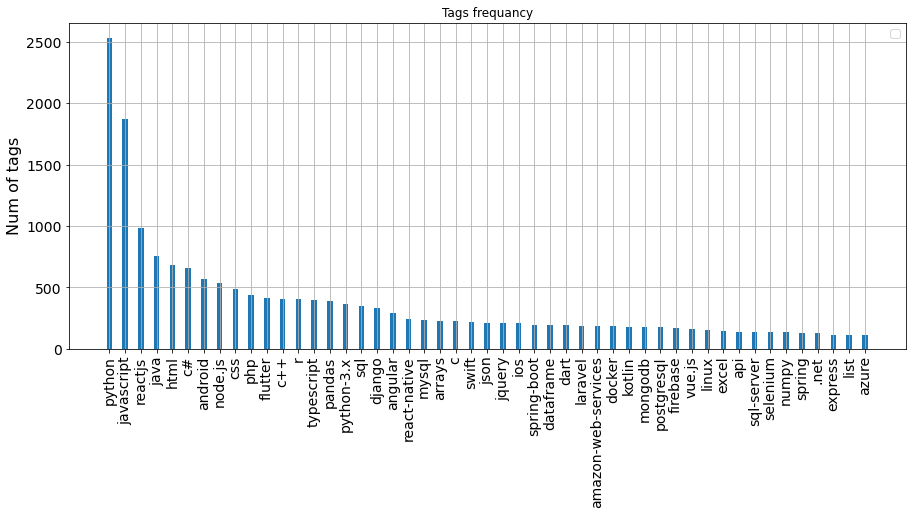

No handles with labels found to put in legend.


2  months ago


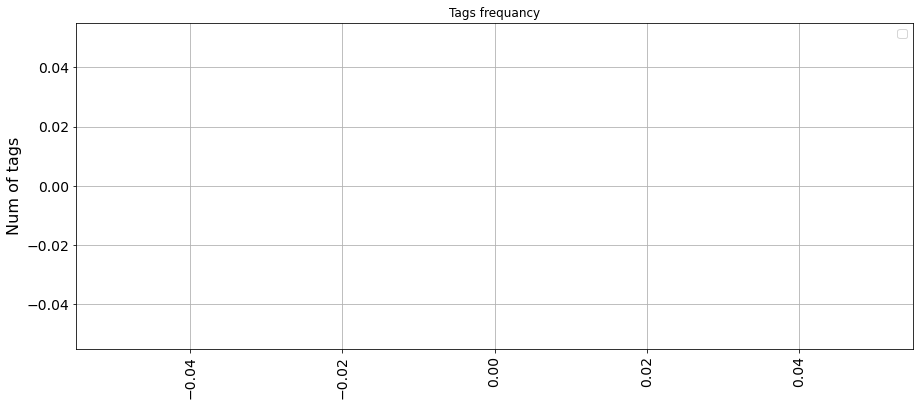

In [70]:
# Need to add nore data in database for last graphic
temporal_arr = ['2022-02-01', '2022-01-01', '2021-12-01', '2021-11-01']

for t in range(len(temporal_arr)-1):
    t1 = temporal_arr[t]
    t2 = temporal_arr[t+1]
    tags_df_temp = posts_data[(posts_data['CreationDate']<=t1)&(posts_data['CreationDate']>=t2)]['Tags'].apply(lambda x: x.split(' ')).explode()
    most_tags_labels_temp = tags_df_temp.value_counts().keys()[1:50]
    most_tags_values_temp = tags_df_temp.value_counts().values[1:50]

    labels = labels_arr
    width = 0.35

    fig, ax = plt.subplots()
    plt.bar(most_tags_labels_temp, most_tags_values_temp, width, label='')

    plt.ylabel('Num of tags')
    plt.title('Tags frequancy')
    plt.legend()
    plt.xticks(rotation = 90)
    plt.grid()
    print(t, ' months ago')

    plt.show()

----------

### Next possible steps:

 - Use comments data for analytics. Unfortunately, I didn't have time to add this step, but it may be quite interesting in the following steps.  
 - Use larger phrases. 
 - It is better to identify the right words and phrases, to weed out their useless parts. If you receive a more detailed task, you will be able to talk in more detail about which phrases will be useful and which will not. 
 - Improve algorithms to look at data better. With the current approach, if you look at longer terms, then the core breaks.
 - After it is possible to add data for each of the months, it will be possible to track the trend of changes in popular words and phrases.
 - Add new features, such as score and view_count. With this features we can check which sphere more popular right now.